# Анализ и оценка результатов A/B-теста

В нашем распоряжении есть датасет с действиями пользователей, техническое задание и несколько вспомогательных датасетов.

Задачи проекта:
* оценить корректность проведения теста
* проанализировать результаты теста

СОДЕРЖАНИЕ

Шаг 1. Техническое задание и описание данных

Шаг 2. Загрузка данных и предобработка данных

Шаг 3. Проверка соотетствия техническому заданию

    3.1 Проверка дат
    3.2 Количество пользователей в тесте
    3.3 Пересечение в проводимых теста
    3.4 Маркетинговые события
    3.5 События пользователей
    3.6 Выводы

Шаг 4. Исследовательский анализ данных

    4.1 Похожесть групп
        4.1.1 Количество событий
        4.1.2 Регистрация пользователей по датам
        4.1.3 Распределение по устройствам
        4.1.4 График кумулятивной выручки по группам
        4.1.5 График кумулятивного среднего чека по группам
        4.1.6 График кумулятивного среднего количества заказов на пользователя по группам
    4.2 Воронка
    4.3 Выводы

Шаг 5. Оценка результатов A/B-тестирования

    5.1 Результаты A/В-тестирования
    5.2 Проверка статистической разницы долей
    5.3 Выводы

Шаг 6. Выводы и рекомендации



=======

## Техническое задание и описание данных

### Техническое задание

* Название теста: recommender_system_test;
* Группы: А (контрольная), B (новая платёжная воронка);
* Дата запуска: 2020-12-07;
* Дата остановки набора новых пользователей: 2020-12-21;
* Дата остановки: 2021-01-04;
* Аудитория: 15% новых пользователей из региона EU;
* Назначение теста: тестирование изменений, связанных с внедрением улучшенной рекомендательной системы;
* Ожидаемое количество участников теста: 6000.
* Ожидаемый эффект: за 14 дней с момента регистрации в системе пользователи покажут улучшение каждой метрики не менее, чем на 10%:
    * конверсии в просмотр карточек товаров — событие product_page
    * просмотры корзины — product_cart
    * покупки — purchase.

### Описание данных

<b>Файл ab_project_marketing_events.csv — календарь маркетинговых событий на 2020 год</b>

Структура файла:  
* name — название маркетингового события;
* regions — регионы, в которых будет проводиться рекламная кампания;
* start_dt — дата начала кампании;
* finish_dt — дата завершения кампании.

<b>Файл final_ab_new_users.csv — все пользователи, зарегистрировавшиеся в интернет-магазине в период с 7 по 21 декабря 2020 года</b>
Структура файла:
* user_id — идентификатор пользователя;
* first_date — дата регистрации;
* region — регион пользователя;
* device — устройство, с которого происходила регистрация.

<b>Файл final_ab_events.csv — все события новых пользователей в период с 7 декабря 2020 по 4 января 2021 года </b>

Структура файла:
* user_id — идентификатор пользователя;
* event_dt — дата и время события;
* event_name — тип события;
* details — дополнительные данные о событии. Например, для покупок, purchase, в этом поле хранится стоимость покупки в долларах.

<b>Файл final_ab_participants.csv — таблица участников тестов</b>

Структура файла:
* user_id — идентификатор пользователя;
* ab_test — название теста;
* group — группа пользователя.

## Загрузка данных

In [77]:
# подкючение библиотек
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

from datetime import date

from plotly.subplots import make_subplots
import plotly.graph_objects as go
import plotly.express as px

import math 


In [78]:
# Сброс ограничений на количество символов в записи
pd.set_option('display.max_colwidth', None)

# настройка формата для десятичных значений
pd.options.display.float_format = '{:,.2f}'.format

# размер графиков по умолчанию
sns.set(rc={'figure.figsize':(9,7)})

# игнорирование замечаний
import warnings
warnings.filterwarnings('ignore')

In [80]:
# вывод данных - первых пяти строк каждого файла
i = 0
for f in file_list:
    print('File: ', end='')
    print(file_name_list[i])
    display(f.head())
    print('\n')
    i += 1

File: marketing_events


,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
1,St. Valentine's Day Giveaway,"EU, CIS, APAC, N.America",2020-02-14,2020-02-16
2,St. Patric's Day Promo,"EU, N.America",2020-03-17,2020-03-19
3,Easter Promo,"EU, CIS, APAC, N.America",2020-04-12,2020-04-19
4,4th of July Promo,N.America,2020-07-04,2020-07-11




File: new_users


,user_id,first_date,region,device
0,D72A72121175D8BE,2020-12-07,EU,PC
1,F1C668619DFE6E65,2020-12-07,N.America,Android
2,2E1BF1D4C37EA01F,2020-12-07,EU,PC
3,50734A22C0C63768,2020-12-07,EU,iPhone
4,E1BDDCE0DAFA2679,2020-12-07,N.America,iPhone




File: events


,user_id,event_dt,event_name,details
0,E1BDDCE0DAFA2679,2020-12-07 20:22:03,purchase,99.99
1,7B6452F081F49504,2020-12-07 09:22:53,purchase,9.99
2,9CD9F34546DF254C,2020-12-07 12:59:29,purchase,4.99
3,96F27A054B191457,2020-12-07 04:02:40,purchase,4.99
4,1FD7660FDF94CA1F,2020-12-07 10:15:09,purchase,4.99




File: participants


,user_id,group,ab_test
0,D1ABA3E2887B6A73,A,recommender_system_test
1,A7A3664BD6242119,A,recommender_system_test
2,DABC14FDDFADD29E,A,recommender_system_test
3,04988C5DF189632E,A,recommender_system_test
4,482F14783456D21B,B,recommender_system_test


In [81]:
# преобразование данных о времени

# таблица marketing_events
marketing_events['start_dt'] = pd.to_datetime(marketing_events['start_dt'])
marketing_events['finish_dt'] = pd.to_datetime(marketing_events['finish_dt'])

# таблица new_users
new_users['first_date'] = pd.to_datetime(new_users['first_date'])

# таблица events
events['event_dt'] = pd.to_datetime(events['event_dt']).dt.date
#events['event_dt'] = pd.to_datetime(events['event_dt'])


Проверим типы данных, пропуски и дубликаты в таблицах

In [82]:
i = 0
for f in file_list:
  print('File:', end='')
  print(file_name_list[i])
  i += 1
  print('Info:')
  print(f.info())
  print('\n')
  print('Number of duplicates:')
  print(f.duplicated().value_counts())
  print('*'*50)
  print('\n')

File:marketing_events
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14 entries, 0 to 13
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   name       14 non-null     object        
 1   regions    14 non-null     object        
 2   start_dt   14 non-null     datetime64[ns]
 3   finish_dt  14 non-null     datetime64[ns]
dtypes: datetime64[ns](2), object(2)
memory usage: 576.0+ bytes
None


Number of duplicates:
False    14
dtype: int64
**************************************************


File:new_users
Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 61733 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     61733 non-null  object        
 1   first_date  61733 non-null  datetime64[ns]
 2   region      61733 non-null  object        
 3   device      61733 non-null  object        


В таблице events присутствуют пропуски в поле details 

In [83]:
# уникальные значения поля details
events['details'].unique()

array([ 99.99,   9.99,   4.99, 499.99,    nan])

Скорее всего это поле содержит цену товара и таких значений всего четыре, не считая Nan. 

In [84]:
# каким событиям соответствуют пропуски в поле 'details'
events.query('details != details')['event_name'].unique()

array(['product_cart', 'product_page', 'login'], dtype=object)

In [85]:
events['event_name'].unique()

array(['purchase', 'product_cart', 'product_page', 'login'], dtype=object)

Видно, что события, не содержащие цену  - 'product_cart', 'product_page', 'login' - связаны с просмотром корзины, карточки товара или логином. Соответственно, числовое значение присутствует только в событии 'purchase' (покупка). Пропуски в данном поле заполнять никак не будем

Пропусков (кроме таблицы events) и дубликатов нет.

## Соответствие техническому заданию

### Проверка дат

In [86]:
# начало и конец теста
test_start = pd.to_datetime('2020-12-07')
test_end =  pd.to_datetime('2021-01-04')
stop_new_users = pd.to_datetime('2020-12-21')

In [87]:
# начальный размер датасета
start_len_df = len(new_users)

In [88]:
# период регистрации пользователей
print('Минимальная дата регистрации пользователя: ', new_users['first_date'].min().date())
print('Максимальная дата регистрации пользователя: ', new_users['first_date'].max().date())

Минимальная дата регистрации пользователя:  2020-12-07
Максимальная дата регистрации пользователя:  2020-12-23


В таблице new_users нет пользователей, которые зарегистрировались до старта теста. 
Дата остановки набора новых пользователей по техническому заданию 2020-12-21, а в таблице присутствуют пользователи регистрацией после этой даты. Это не соответствует техническому заданию, отфильтруем лишние данные

In [89]:
# объединим таблицы participants с нужным тестом и new_users
df_part = participants.query('ab_test == "recommender_system_test"').merge(new_users, how='left')
df_part['first_date'].describe()

count                    6701
unique                     15
top       2020-12-21 00:00:00
freq                      723
first     2020-12-07 00:00:00
last      2020-12-21 00:00:00
Name: first_date, dtype: object

Конец регистрации пользователей, попавших в тест, соответствует техническому заданию

In [90]:
new_users_f = new_users.query('first_date <= @stop_new_users')
new_users_f.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 56470 entries, 0 to 61732
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     56470 non-null  object        
 1   first_date  56470 non-null  datetime64[ns]
 2   region      56470 non-null  object        
 3   device      56470 non-null  object        
dtypes: datetime64[ns](1), object(3)
memory usage: 2.2+ MB


In [91]:
print(f'При первой фильтрации датасет уменьшился на {(1 - len(new_users_f) / start_len_df):.2%}')

При первой фильтрации датасет уменьшился на 8.53%


In [92]:
# даты событий в таблице events
print('Минимальная дата события: ', events['event_dt'].min())
print('Максимальная дата события: ',events['event_dt'].max())

Минимальная дата события:  2020-12-07
Максимальная дата события:  2020-12-30


In [93]:
pd.to_datetime(events['event_dt']).describe()

count                  440317
unique                     24
top       2020-12-21 00:00:00
freq                    32559
first     2020-12-07 00:00:00
last      2020-12-30 00:00:00
Name: event_dt, dtype: object

По условию задания это действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года. Получается, нет данных за с 31 декабря 2020 по 4 января 2021 нет (наверное, сервер на праздники выключили или просто обрезали данные - произошла критическая ошибка сбора данных)

### Количество пользователей в тесте

In [94]:
# Количество всех пользователей из EU в период регистрации теста
len_EU = new_users.query('region == "EU" and @test_start <= first_date <= @stop_new_users')['user_id'].nunique()
len_EU 

42340

In [95]:
# добавим в таблицу участников теста регион участника
new_users_group = pd.merge(participants, new_users_f, how='left')

In [96]:
len_test_EU = new_users_group.query('region == "EU" and ab_test == "recommender_system_test"')['user_id'].nunique()
len_test_EU

6351

In [97]:
print(f'Доля участников теста из региона EU от всех новых пользователей региона EU {len_test_EU / len_EU:.2%}')

Доля участников теста из региона EU от всех новых пользователей региона EU 15.00%


Соответствует техническому заданию

In [98]:
# их каких регионов присутствуют участники в тесте
region = new_users_group.groupby('region').agg({'user_id':'nunique'})
region.columns = ['unique_users']
region['perc'] = region['unique_users'] / sum(region['unique_users'])
region

,unique_users,perc
region,,
APAC,72,0.00
CIS,55,0.00
EU,15314,0.98
N.America,223,0.01


В таблице есть данные об участниках из других регионов, применим фильтр

In [99]:
# оставляем в тесте только участников из EU
new_users_group = new_users_group.query('region == "EU"')
new_users_group.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


### Пересечение в проводимых тестах

In [100]:
# уникальные названия A/B тестов
new_users_group['ab_test'].unique()

array(['recommender_system_test', 'interface_eu_test'], dtype=object)

В таблице new_users_group содержатся названия двух тестов, нас интересует только 'recommender_system_test', при этом пользователи не должны участвовать в конкурирующем тесте в составе экспериментальной группы

In [101]:
# фильтр по названию теста
participants_1 = new_users_group.query('ab_test == "recommender_system_test"')
participants_2 = new_users_group.query('ab_test == "interface_eu_test"')

In [102]:
# количество уникальных участников по группам в первом тесте
participants_1.groupby('group')['user_id'].nunique()

group
A    3634
B    2717
Name: user_id, dtype: int64

In [103]:
# количество уникальных участников по группам во втором
participants_2.groupby('group')['user_id'].nunique()

group
A    5342
B    5223
Name: user_id, dtype: int64

Найдем, сколько участников из теста recommender_system_test попали в конкурирующий тест, по группам

In [104]:
# участники тестов по группам

# тест recommender_system_test
participants_1_A = participants_1.query('group == "A"')
participants_1_B = participants_1.query('group == "B"')

# тест interface_eu_test
#participants_2_A = participants_2.query('group == "A"')
participants_2_B = participants_2.query('group == "B"')

In [105]:
# пересечение множеств пользователей, которые оказались в группах А в двух тестах
count_group_A = len(set(participants_1_A['user_id']).intersection(set(participants_2_B['user_id'])))
# количество пользователей попавших в обе группы A
count_group_A

439

In [106]:
# пересечение множеств пользователей, которые оказались в группах B в двух тестах
count_group_B = len(set(participants_1_B['user_id']).intersection(set(participants_2_B['user_id'])))
# количество пользователей попавших в обе группы B
count_group_B

344

In [107]:
count_group_A = count_group_A / len(set(participants_1_A['user_id']))

In [108]:
print(f'Доля участников конкурирующего теста из группы А {count_group_A:.2%}')

Доля участников конкурирующего теста из группы А 12.08%


In [109]:
count_group_B = count_group_B / len(set(participants_1_B['user_id']))

In [110]:
print(f'Доля участников конкурирующего теста из группы А {count_group_B:.2%}')

Доля участников конкурирующего теста из группы А 12.66%


Таким образом, несмотря на то, что у нас есть пользователи, которые принимали участие в конкурирующем тесте, доли в группах А и В пользователей из экспериментальной группы В другого теста практически равны, значит, воздействие на группы было равномерным

Проверка пользователей, которые могли попасть в обе группы нашего теста

In [111]:
participants_1['user_id'].value_counts()

D1ABA3E2887B6A73    1
469C6FD4044B1668    1
FAEC4312DD2E4909    1
B05232A00CE7DA9B    1
D070FD0BFE78DFA4    1
                   ..
CCAF138D12385DF2    1
C1760622B65C9B84    1
794D683C2E501D1E    1
C3E0EB602D1FCBD1    1
80712ED4EA1B52A5    1
Name: user_id, Length: 6351, dtype: int64

В данных нет пользователей, которые могли попасть в группу А и в группу В одновременно

In [112]:
participants_1.head()

,user_id,group,ab_test,first_date,region,device
0,D1ABA3E2887B6A73,A,recommender_system_test,2020-12-07,EU,PC
1,A7A3664BD6242119,A,recommender_system_test,2020-12-20,EU,iPhone
2,DABC14FDDFADD29E,A,recommender_system_test,2020-12-08,EU,Mac
3,04988C5DF189632E,A,recommender_system_test,2020-12-14,EU,iPhone
4,482F14783456D21B,B,recommender_system_test,2020-12-14,EU,PC


### Маркетинговые события

In [113]:
# маркетинговые события, которые проходят во время теста
marketing_events.query('@test_start <= start_dt <= @test_end or @test_start <= finish_dt <= @test_end')

,name,regions,start_dt,finish_dt
0,Christmas&New Year Promo,"EU, N.America",2020-12-25,2021-01-03
10,CIS New Year Gift Lottery,CIS,2020-12-30,2021-01-07


Время проведения теста совпало со временем проведения двух маркетинговых событий, однако "CIS New Year Gift Lottery" проходило только в регионе CIS, а наших пользователей частично застронуло событие "Christmas&New Year Promo"

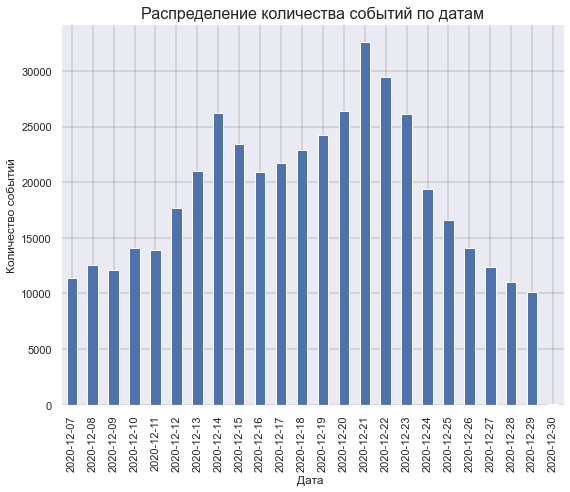

In [114]:
# общий график распределения событий по дням
events.groupby('event_dt')['event_name'].count().plot(kind='bar')

plt.ylabel('Количество событий')
plt.xlabel('Дата ')
plt.title('Распределение количества событий по датам', fontsize=16)
plt.grid(visible=True, linewidth=0.2, color='#000000')

Если оценивать влияние маркетинговой акции на события пользователей, то нельзя сказать, что было какое-то сильное влияние - снижение количества событий начиная с 24 декабря достаточно плавное, а акция была запущена 25 декабря

### События пользователей

In [115]:
# типы событий пользователей
events['event_name'].value_counts()

login           189552
product_page    125563
purchase         62740
product_cart     62462
Name: event_name, dtype: int64

Мы должны отфильтровать события, которые пользователи совершили после 14 дней от регистрации. Добавим в таблицу events для каждого пользователя день совершения события


In [116]:
# добавляем пользователям дату регистрации
final_df = pd.merge(events, participants_1, how='right')

In [117]:
# количество пользователей по группам до фильтрации по событиям
final_df.groupby('group')['user_id'].nunique()

group
A    3634
B    2717
Name: user_id, dtype: int64

In [118]:
# добавим столбец с днем события от начала регистрации

final_df[['first_date','event_dt']] = final_df[['first_date','event_dt']].apply(pd.to_datetime) #if conversion required
final_df['event_lifetime'] = (final_df['event_dt'] - final_df['first_date']).dt.days

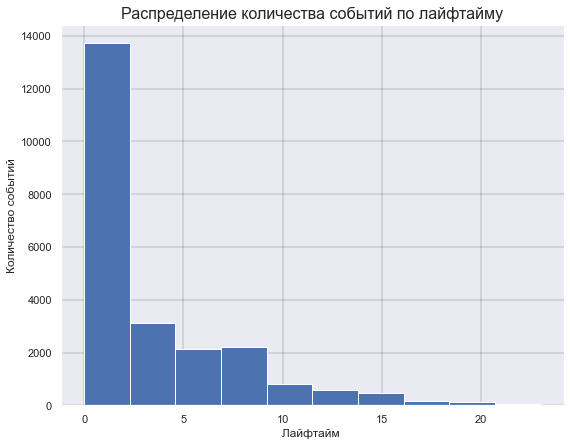

In [119]:
# гистрограмма событий по лайфтайму
final_df['event_lifetime'].plot(kind='hist', bins=10)

plt.ylabel('Количество событий')
plt.xlabel('Лайфтайм ')
plt.title('Распределение количества событий по лайфтайму', fontsize=16)
plt.grid(visible=True, linewidth=0.2, color='#000000')

Видно, что основная масса событий происходит в день регистрации, после 10 дня количество событий снижается, поэтому, применив  фильтр в 14 дней, мы не потеряем основную картину, так как - всё основное количество событий случается до 10 дня

In [120]:
final_df = final_df.query('event_lifetime < 14')

In [121]:
# количество уникальных пользователей 
len_events_14 = final_df['user_id'].nunique()
len_events_14 

3481

In [122]:
# количество пользователь по группа после фильтрации событий
final_df.groupby('group')['user_id'].nunique()

group
A    2604
B     877
Name: user_id, dtype: int64

После фильтрации по событиям пользователей в группе А стало на 28% меньше, пользователей в группе В - на 68%. Пользователи в группах распределены неравномерно.

In [123]:
# проверка доли пользователей из региона EU от изначального количество пользователей
print(f'Доля участников теста из региона EU от всех новых пользователей региона EU {len_events_14 / len_EU:.2%}')

Доля участников теста из региона EU от всех новых пользователей региона EU 8.22%


<b>Таким образом, после применения фильтров по условиям технического задания аудитория теста составляет 8.22% новых пользователей из региона EU (техническое задание предполагало 15% участников). Ожидаемое количество участников теста  - 6000, номинальное - 3481</b>

### Выводы

* В таблице new_users нет пользователей, которые зарегистрировались до старта теста. Дата остановки набора новых пользователей по техническому заданию 2020-12-21, а в таблице присутствуют пользователи регистрацией после этой даты. 
* По условию задания это действия новых пользователей в период с 7 декабря 2020 по 4 января 2021 года. Получается, нет данных  с 31 декабря 2020 по 4 января 2021  (наверное, сервер на праздники выключили или просто обрезали данные - произошла критическая ошибка сбора данных)
* Несмотря на то, что  есть пользователи, которые принимали участие в конкурирующем тесте, доли в группах А и В пользователей из экспериментальной группы В другого теста практически равны, значит, воздействие на группы было равномерным.
* В данных нет пользователей, которые могли попасть в группу А и в группу В одновременно.
* Время проведения теста совпало со временем проведения двух маркетинговых событий, однако "CIS New Year Gift Lottery" проходило только в регионе CIS, а наших пользователей частично застронуло событие "Christmas&New Year Promo"
* Если оценивать влияние маркетинговой акции на события пользователей, то нельзя сказать, что было какое-то сильное влияние - снижение количества событий начиная с 24 декабря достаточно плавное, а акция была запущена 25 декабря
* Основная масса событий происходит в день регистрации, после 10 дня количество событий снижается, поэтому, применив фильтр в 14 дней, мы не потеряем основную картину, так как - всё основное количество событий случается до 10 дня
* Доля участников теста из региона EU от всех новых пользователей региона EU 8.22% после применения фильтров
* После фильтрации по событиям пользователей в группе А стало на 28% меньше, пользователей в группе В - на 68%. Пользователи в группах распределены неравномерно.


## Исследовательский анализ данных

### Похожесть групп


Сравним группы теста по нескольким параметрам для того, чтобы найти сходства или различия в поведениях этих групп

In [124]:
final_df.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,event_lifetime
0,D1ABA3E2887B6A73,2020-12-07,purchase,99.99,A,recommender_system_test,2020-12-07,EU,PC,0.00
2,D1ABA3E2887B6A73,2020-12-07,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,PC,0.00
4,D1ABA3E2887B6A73,2020-12-07,product_page,NaN,A,recommender_system_test,2020-12-07,EU,PC,0.00
6,D1ABA3E2887B6A73,2020-12-07,login,NaN,A,recommender_system_test,2020-12-07,EU,PC,0.00
8,A7A3664BD6242119,2020-12-20,product_page,NaN,A,recommender_system_test,2020-12-20,EU,iPhone,0.00


In [125]:
final_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22620 entries, 0 to 26289
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype         
---  ------          --------------  -----         
 0   user_id         22620 non-null  object        
 1   event_dt        22620 non-null  datetime64[ns]
 2   event_name      22620 non-null  object        
 3   details         3103 non-null   float64       
 4   group           22620 non-null  object        
 5   ab_test         22620 non-null  object        
 6   first_date      22620 non-null  datetime64[ns]
 7   region          22620 non-null  object        
 8   device          22620 non-null  object        
 9   event_lifetime  22620 non-null  float64       
dtypes: datetime64[ns](2), float64(2), object(6)
memory usage: 1.9+ MB


In [126]:
# проверка на дубликаты
final_df.duplicated().value_counts()

False    22620
dtype: int64

In [127]:
# проверка количества групп и пользователей в каждой группе
final_df.groupby('group')['user_id'].nunique()

group
A    2604
B     877
Name: user_id, dtype: int64

В группе А 2604 пользователя, в группе В - 877, что на 66% меньше

In [128]:
# поиск пользователей, которые могли попасть в обе группы
df = final_df.groupby('user_id').agg({'group': 'nunique'}).sort_values(by='group', ascending=False)
df

,group
user_id,
001064FEAAB631A1,1
ABABE1BAB6C77540,1
AB0D9A9D709F476A,1
AB30C03FCEC72466,1
AB4EA096BF581CFB,1
...,...
564975AFF8E15C0C,1
5650B53B91DC98BB,1
565EF59DDD36B95B,1


In [129]:
# cоздание датафрейм datesGroups с уникальными парами значений 'event_dt' и 'group', таблицы final_df. 
# и удаление дубликатов методом drop_duplicates()
datesGroups = final_df[['event_dt', 'group']].drop_duplicates()
datesGroups.head()

,event_dt,group
0,2020-12-07,A
8,2020-12-20,A
9,2020-12-21,A
10,2020-12-25,A
14,2020-12-08,A


In [130]:
# объяление переменной ordersAggregated, содержащую: 
# дату; группу A/B-теста; 
# число событий в группе теста по указанную дату включительно;
# число уникальных пользователей, совершивших хотя бы 1 событие в группе теста по указанную дату включительно;
# суммарную выручку заказов в группе теста по указанную дату включительно.

ordersAggregated = datesGroups.apply(
    lambda x: final_df[
        # функция np.logical_and выбирает подмножество строк, удовлетворяющее нескольким условиям
        np.logical_and(
            final_df['event_dt'] <= x['event_dt'], final_df['group'] == x['group']
        )
    ].agg(
        {
            'event_dt': 'max',
            'group': 'max',
            'event_name': 'count',
            'user_id': 'nunique',
            'details': 'sum',
            
            
        }
    ),
    axis=1,
).sort_values(by=['event_dt', 'group'])

ordersAggregated.head()

,event_dt,group,event_name,user_id,details
0,2020-12-07,A,318,148,"1,104.57"
105,2020-12-07,B,356,163,704.41
14,2020-12-08,A,631,240,"1,859.24"
195,2020-12-08,B,594,207,"1,189.08"
55,2020-12-09,A,1002,322,"2,618.77"


In [131]:
# информация о количестве покупок
purchase_users = final_df[final_df['event_name'] == "purchase"]
purchase = purchase_users.groupby(['event_dt', 'group'])['details'].count().reset_index()
purchase.head()

,event_dt,group,details
0,2020-12-07,A,43
1,2020-12-07,B,59
2,2020-12-08,A,33
3,2020-12-08,B,33
4,2020-12-09,A,47


In [132]:
# добавим в датафрейм количество покупок для каждой даты и группы
ordersAggregated = ordersAggregated.merge(purchase, left_on=['event_dt', 'group'], right_on=['event_dt', 'group'])
ordersAggregated.rename(columns = {'details_x': 'details', 'details_y': 'orders'}, inplace = True)
ordersAggregated.head()

,event_dt,group,event_name,user_id,details,orders
0,2020-12-07,A,318,148,"1,104.57",43
1,2020-12-07,B,356,163,704.41,59
2,2020-12-08,A,631,240,"1,859.24",33
3,2020-12-08,B,594,207,"1,189.08",33
4,2020-12-09,A,1002,322,"2,618.77",47


In [133]:
# датафрейм с кумулятивным количеством событий, оплат и кумулятивной выручкой по дням в группе А
cumulativeRevenueA = ordersAggregated[ordersAggregated['group']=='A'][['event_dt','details', 'orders', 'event_name', 'user_id']]

# датафрейм с кумулятивным количеством событий,  оплат  и кумулятивной выручкой по дням в группе B
cumulativeRevenueB = ordersAggregated[ordersAggregated['group']=='B'][['event_dt','details', 'orders', 'event_name', 'user_id']]

#### Количество событий 

In [134]:
# создаем датафрейм с двумя столбцами 'user_id' и 'event_name', который хранит количество событий каждого пользователя
eventsByUsers = (
    final_df.groupby('user_id', as_index=False)
    .agg({'event_name': 'count'})
)
eventsByUsers.columns = ['user_id', 'events']

# вывод первых 10 строк датафрейма
display(eventsByUsers.sort_values(by='events', ascending=False).head(10))

,user_id,events
224,1198061F6AF34B7B,24
2825,CED71698585A2E46,24
1821,89545C7F903DBA34,21
2516,B8EF6F0325A9979F,21
220,115EBC1CA027854A,21
2182,A2DB18F90D9E3362,20
1542,7347C03E6A300EFD,20
1762,84DC74ED5E60BA6A,20
576,2B8FD20CA8A2A616,20
3391,F9D53F0BA957F728,20


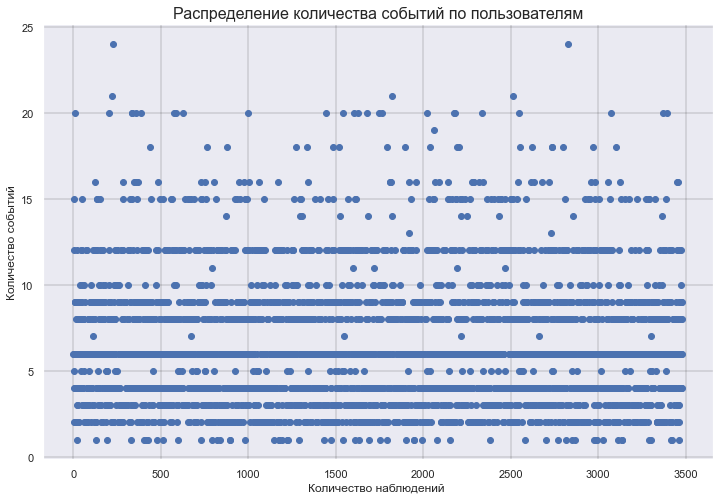

In [135]:
# серия из чисел от 0 до количества наблюдений в eventsByUsers
x_values = pd.Series(range(0, len(eventsByUsers)))

# построение диаграммы методом scatter()
plt.figure(figsize=(12, 8))
plt.scatter(x_values, eventsByUsers['events']) 
plt.ylabel('Количество событий')
plt.xlabel('Количество наблюдений ')
plt.title('Распределение количества событий по пользователям', fontsize=16)
plt.grid(visible=True, linewidth=0.2, color='#000000')

Количество событий распределено неравномерно, но свыше 13 событий совершают уже не так много пользователей, как и меньше двух

In [136]:
# Метод np.percentile('column', [percentile1, percentile2]) находит перцентили.
print(np.percentile(eventsByUsers['events'], [95,99]))

[14. 18.]


Не более 5% посетителей совершили 14 событий. И не более 1%  - больше 18. 

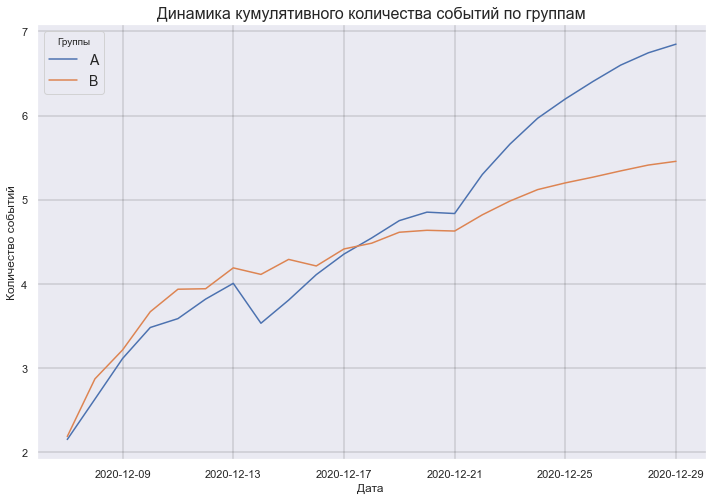

In [137]:
# Построим графики среднего количества событий по группам — разделим кумулятивную число событий на уникальных пользователей
plt.figure(figsize=(12, 8))
plt.plot(cumulativeRevenueA['event_dt'], cumulativeRevenueA['event_name']/cumulativeRevenueA['user_id'], label='A')
plt.plot(cumulativeRevenueB['event_dt'], cumulativeRevenueB['event_name']/cumulativeRevenueB['user_id'], label='B')
plt.legend(title= 'Группы', title_fontsize = 10,  prop = {'size' : 14}) 
plt.ylabel('Количество событий')
plt.xlabel('Дата ')
plt.title('Динамика кумулятивного количества событий по группам', fontsize=16)
plt.grid(visible=True, linewidth=0.2, color='#000000')

Кумулятивное количество событий на протяжении теста растет в двух группах, после 17 декабря группа А становится лидером и показывает более сильный рост, чем группа В. К концу теста среднее значение отличается примерно на 1 событие на пользователя

In [138]:
# присоеденили количество событий на пользователя
final_df = final_df.merge(eventsByUsers, how='left')

In [139]:
final_df.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,event_lifetime,events
0,D1ABA3E2887B6A73,2020-12-07,purchase,99.99,A,recommender_system_test,2020-12-07,EU,PC,0.00,4
1,D1ABA3E2887B6A73,2020-12-07,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,PC,0.00,4
2,D1ABA3E2887B6A73,2020-12-07,product_page,NaN,A,recommender_system_test,2020-12-07,EU,PC,0.00,4
3,D1ABA3E2887B6A73,2020-12-07,login,NaN,A,recommender_system_test,2020-12-07,EU,PC,0.00,4
4,A7A3664BD6242119,2020-12-20,product_page,NaN,A,recommender_system_test,2020-12-20,EU,iPhone,0.00,6


In [140]:
# слетело
final_df['event_dt'] =  pd.to_datetime(final_df['event_dt']).dt.date
final_df['first_date'] =  pd.to_datetime(final_df['first_date']).dt.date

# распределение по группам
final_df_A = final_df.query('group == "A"')
final_df_B = final_df.query('group == "B"')

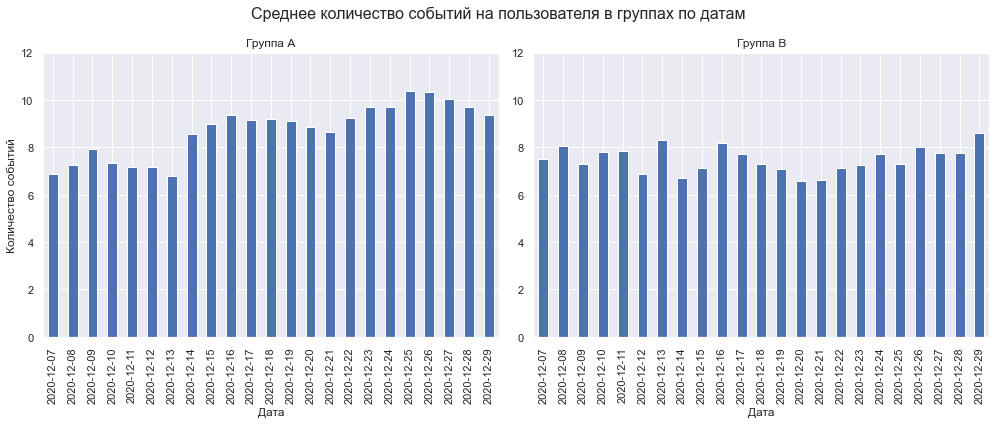

In [141]:
# график количества событий по группе А
final_df_A.groupby('event_dt')['events'].mean().plot(
    grid=True, 
    kind='bar', 
    figsize=(14,6), 
    ax=plt.subplot(1, 2, 1)
)
plt.legend().set_visible(False)
plt.ylabel('Количество событий')
plt.xlabel('Дата')
plt.title('Группа А')
plt.ylim(0, 12)

# график количества событий по группе В
final_df_B.groupby('event_dt')['events'].mean().plot(grid=True, kind='bar', figsize=(14,6), ax=plt.subplot(1, 2, 2))
plt.xlabel('Дата')
plt.title('Группа B')
plt.ylim(0, 12)

plt.suptitle('Среднее количество событий на пользователя в группах по датам', fontsize=16)
plt.tight_layout()

plt.show()

На графике еще раз подтвердился факт, что в среднем событий на пользователя в группе А было больше. 
С 14 декабря в группе А наблюдается резкий рост среднего числа событий с пиком 26 декабря и дальнейшим снижением к значениям начала теста.

В группе В пики количества событий приходятся на 13, 16 и 29 декабря.

Всё это наводит на мысль о том, что тест приходится на праздничные дни + маркетинговая акция в регионе, пользователи выбирают подарки себе и друзьям, тратят деньги, а после праздника (в данном случае, вероятно, Рождественская неделя), покупки идут на спад. 


#### Регистрация пользователей по датам

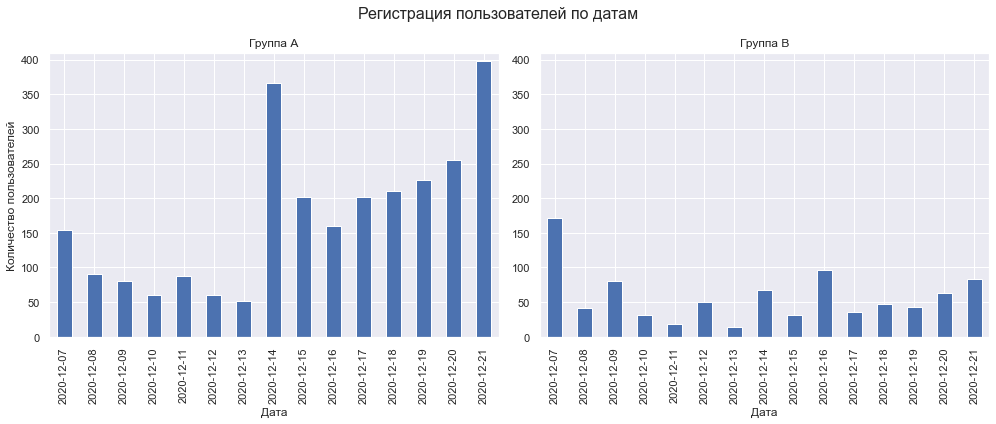

In [142]:
# график регистраций пользователей по группе А
final_df_A.groupby('first_date')['user_id'].nunique().plot(
    grid=True, 
    kind='bar', 
    figsize=(14,6), 
    ax=plt.subplot(1, 2, 1)
)
plt.legend().set_visible(False)
plt.ylabel('Количество пользователей')
plt.xlabel('Дата')
plt.title('Группа А')
plt.ylim(0, 410)

#  график регистраций пользователей  по группе В
final_df_B.groupby('first_date')['user_id'].nunique().plot(
    grid=True, 
    kind='bar', 
    figsize=(14,6), 
    ax=plt.subplot(1, 2, 2)
)
plt.xlabel('Дата')
plt.title('Группа B')
plt.ylim(0, 410)

plt.suptitle('Регистрация пользователей по датам', fontsize=16)
plt.tight_layout()

plt.show()

В первый день пользователи регистрировались в обе группы практически одинаково, затем произошел разброс. Количество пользователей в пиковые даты 14 декабря в группе А на 80% больше, чем в тот же день в группе В (второй пик в группе А - 21 декабря примерно на столько же процентов больше, чем в группе В в тот же день).

В группе А три пиковых дня: 7, 14, 21 декабря

В группе В четыре пиковых дня: 7, 14, 16, 21 декабря

#### Распределение  по устройствам

In [143]:
final_df_A.head()

,user_id,event_dt,event_name,details,group,ab_test,first_date,region,device,event_lifetime,events
0,D1ABA3E2887B6A73,2020-12-07,purchase,99.99,A,recommender_system_test,2020-12-07,EU,PC,0.00,4
1,D1ABA3E2887B6A73,2020-12-07,product_cart,NaN,A,recommender_system_test,2020-12-07,EU,PC,0.00,4
2,D1ABA3E2887B6A73,2020-12-07,product_page,NaN,A,recommender_system_test,2020-12-07,EU,PC,0.00,4
3,D1ABA3E2887B6A73,2020-12-07,login,NaN,A,recommender_system_test,2020-12-07,EU,PC,0.00,4
4,A7A3664BD6242119,2020-12-20,product_page,NaN,A,recommender_system_test,2020-12-20,EU,iPhone,0.00,6


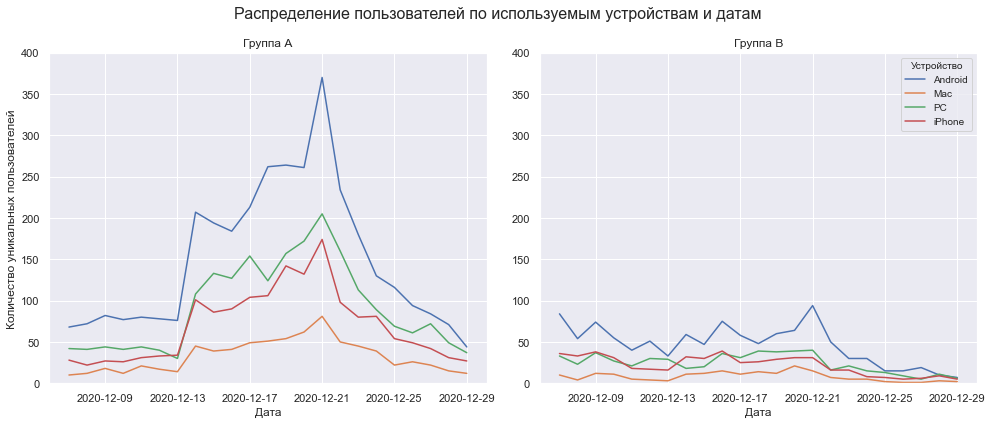

In [144]:
# сводная таблица по датам и устройства в группе А
final_df_A.pivot_table(
    index='event_dt', 
    columns='device', 
    values='user_id', 
    aggfunc='nunique'
).plot(
    grid=True, 
    figsize=(14,6), 
    ax=plt.subplot(1, 2, 1)
)
plt.legend().set_visible(False)
plt.ylabel('Количество уникальных пользователей')
plt.xlabel('Дата')
plt.title('Группа А')
plt.ylim(0, 400)

final_df_B.pivot_table(
    index='event_dt', 
    columns='device', 
    values='user_id', 
    aggfunc='nunique'
).plot(
    grid=True, 
    figsize=(14,6), 
    ax=plt.subplot(1, 2, 2)
)
plt.xlabel('Дата')
plt.title('Группа В')
plt.ylim(0, 400)

plt.legend(title='Устройство', title_fontsize = 10,  prop = {'size' : 10}, bbox_to_anchor= (1, 1));
plt.suptitle('Распределение пользователей по используемым устройствам и датам', fontsize=16)
plt.tight_layout()
plt.ylim(0, 400)

plt.show()

В обеих группах наблюдается преимущественной использование устройств на Android и минимальное использование устройств iPhone.
При этом, если в группе А пользователи PC превышают пользователей Mac, то в группе B эти два устройства все время конкурируют с разными успехами между собой.

#### График кумулятивной выручки по группам

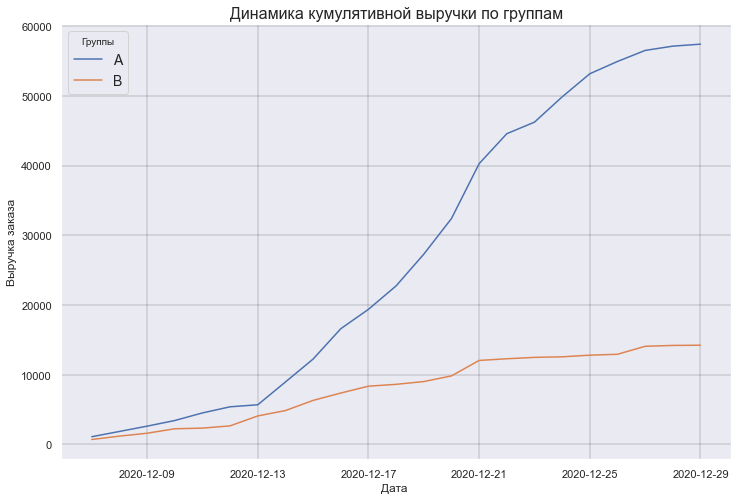

In [145]:
plt.figure(figsize=(12, 8))
# Строим график выручки группы А
plt.plot(cumulativeRevenueA['event_dt'], cumulativeRevenueA['details'], label='A')

# Строим график выручки группы B
plt.plot(cumulativeRevenueB['event_dt'], cumulativeRevenueB['details'], label='B')

plt.legend(title= 'Группы', title_fontsize = 10,  prop = {'size' : 14}) 
plt.ylabel('Выручка заказа')
plt.xlabel('Дата ')
plt.title('Динамика кумулятивной выручки по группам', fontsize=16)
plt.grid(visible=True, linewidth=0.2, color='#000000')

Выручка группы B почти равномерно увеличивается в течение всего теста. Выручка группы A в середине теста резко увеличивается относительно группы B и продолжает лидировать весь остаток теста. Похоже, что на этот период пришлись аномально большие покупки, которые могли быть вызваны маркетинговой акцией

#### График кумулятивного среднего чека по группам¶

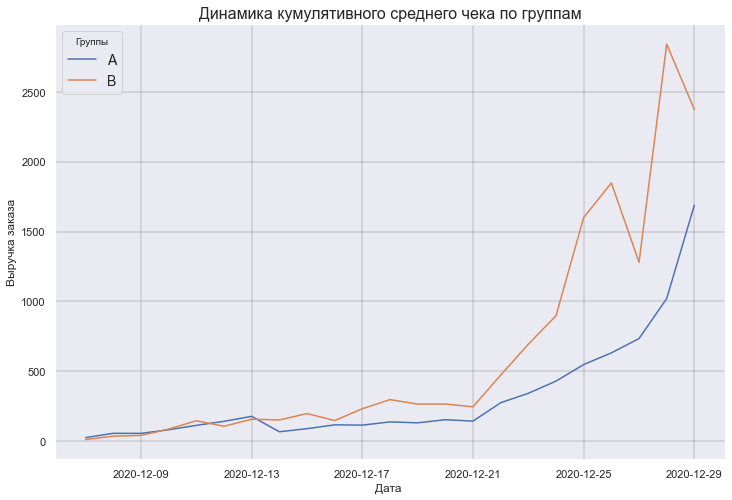

In [146]:
# Построим графики среднего чека по группам — разделим кумулятивную выручку на кумулятивное число покупок
plt.figure(figsize=(12, 8))
plt.plot(cumulativeRevenueA['event_dt'], cumulativeRevenueA['details']/cumulativeRevenueA['orders'], label='A')
plt.plot(cumulativeRevenueB['event_dt'], cumulativeRevenueB['details']/cumulativeRevenueB['orders'], label='B')
plt.legend(title= 'Группы', title_fontsize = 10,  prop = {'size' : 14}) 
plt.ylabel('Выручка заказа')
plt.xlabel('Дата ')
plt.title('Динамика кумулятивного среднего чека по группам', fontsize=16)
plt.grid(visible=True, linewidth=0.2, color='#000000')

Кумулятивное значение среднего чека для группы А на всем протяжении теста росла и начала резко увеличиваться с 21 декабря, вероятно могла повлиять маркетинговая акция, которая проводилась в это время.
Скачкообразное поведение для группы В в середине теста снова дает основание для предположения, что в группу В попали крупные заказы или как-то изменилось их количество.

#### График кумулятивного среднего количества заказов на пользователя по группам

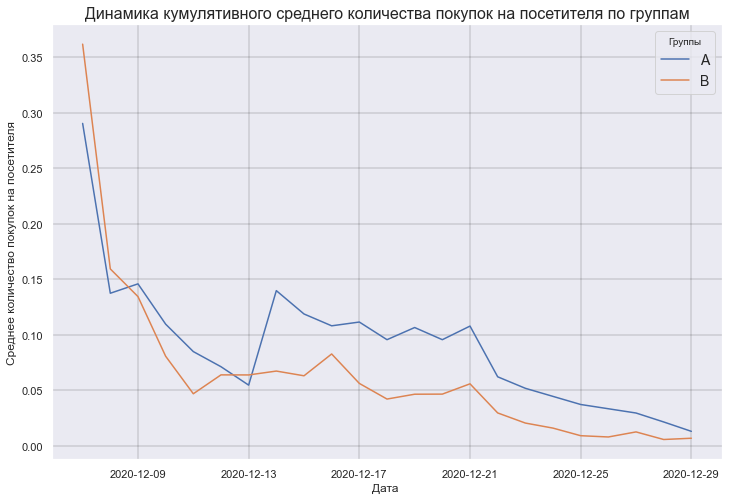

In [147]:
plt.figure(figsize=(12, 8))
# Строим график количества покупок группы А
plt.plot(cumulativeRevenueA['event_dt'], cumulativeRevenueA['orders']/cumulativeRevenueA['user_id'], label='A')

# Строим график количества покупок группы B
plt.plot(cumulativeRevenueB['event_dt'], cumulativeRevenueB['orders']/cumulativeRevenueB['user_id'], label='B')

plt.legend(title= 'Группы', title_fontsize = 10,  prop = {'size' : 14}) 
plt.ylabel('Среднее количество покупок на посетителя')
plt.xlabel('Дата ')
plt.title('Динамика кумулятивного среднего количества покупок на посетителя по группам', fontsize=16)
plt.grid(visible=True, linewidth=0.2, color='#000000')

В начале теста количество покупок в группе B было выше, чем в группе A, но после 9 декабря среднее количество покупок в группе А было примерно на 5% пунктов выше до конца теста (кроме провала группы А примерно 13 декабря)

### Воронка

In [148]:
# количество событий в группе А по уникальным пользователям
final_df_A_funnel = final_df_A.pivot_table(index='event_name',values='user_id',aggfunc='nunique').reindex(
    ['login', 'product_page', 'product_cart',  'purchase']
)

# этапы воронки
stages = final_df_A_funnel.index.to_list()


x_A = final_df_A_funnel['user_id'].to_list()


# количество событий в группе B по уникальным пользователям
final_df_B_funnel = final_df_B.pivot_table(index='event_name',values='user_id',aggfunc='nunique').reindex(
    ['login', 'product_page', 'product_cart',  'purchase']
)
x_B = final_df_B_funnel['user_id'].to_list()


In [149]:
# построение воронки для двух групп
fig = go.Figure()
fig.add_trace(go.Funnel(
    name = 'группа A',    
    y = stages,
    x = x_A,
    textinfo = "value+percent initial"))

fig.add_trace(go.Funnel(
    name = 'группа B',
    y = stages,
    x = x_B,
    textinfo = "value+percent initial"))

fig.update_layout(title='Воронка конверсий действий пользователей')
fig.show()

Просмотров корзины получилось меньше чем покупок, это может означать, что корзина не является обязательным этапом воронки (т.е. реализованы покупки в один клик).

### Выводы

* Не более 5% посетителей совершили 14 событий. И не более 1% - больше 18.
* Кумулятивное количество событий на протяжении теста растет в двух группах, после 17 декабря группа А становится лидером и показывает более сильный рост, чем группа В. К концу теста среднее значение отличается примерно на 1 событие на пользователя.
* В среднем событий на пользователя в группе А было больше. С 14 декабря в группе А наблюдается резкий рост среднего числа событий с пиком 26 декабря и дальнейшим снижением к значениям начала теста.
В группе В пики количества событий приходятся на 13, 16 и 29 декабря.
* В первый день пользователи регистрировались в обе группы практически одинаково, затем произошел разброс. Количество пользователей в пиковые даты 14 декабря в группе А на 80% больше, чем в тот же день в группе В (второй пик в группе А - 21 декабря примерно на столько же процентов больше, чем в группе В в тот же день).
В группе А три пиковых дня: 7, 14, 21 декабря. В группе В четыре пиковых дня: 7, 14, 16, 21 декабря
* В обеих группах наблюдается преимущественной использование устройств на Android и минимальное использование устройств iPhone. При этом, если в группе А пользователи PC превышают пользователей Mac, то в группе B эти два устройства все время конкурируют с разными успехами между собой.
* Выручка группы B почти равномерно увеличивается в течение всего теста. Выручка группы A в середине теста резко увеличивается относительно группы B и продолжает лидировать весь остаток теста. Похоже, что на этот период пришлись аномально большие покупки, которые могли быть вызваны маркетинговой акцией.
* Кумулятивное значение среднего чека для группы А на всем протяжении теста росла и начала резко увеличиваться с 21 декабря, вероятно могла повлиять маркетинговая акция, которая проводилась в это время. Скачкообразное поведение для группы В в середине теста снова дает основание для предположения, что в группу В попали крупные заказы или как-то изменилось их количество.
* Корзина не является обязательным этапом воронки (т.е. реализованы покупки в один клик).

## Оценка результатов A/B-тестирования

### Результаты A/В-тестирования

In [150]:
# объединение данных
df_funnel = pd.concat([final_df_A_funnel,final_df_B_funnel], axis=1).reset_index()
df_funnel.columns = ['event_name', 'count_users_A', 'count_users_B']

# конверсия
df_funnel['cr_A'] = df_funnel['count_users_A'].div(df_funnel['count_users_A'][0])
df_funnel['cr_B'] = df_funnel['count_users_B'].div(df_funnel['count_users_B'][0])

# изменение конверсии
df_funnel['cr_variance'] = df_funnel['cr_B']/df_funnel['cr_A'] * 100 - 100

df_funnel

,event_name,count_users_A,count_users_B,cr_A,cr_B,cr_variance
0,login,2604,876,1.00,1.00,0.00
1,product_page,1685,493,0.65,0.56,-13.03
2,product_cart,782,244,0.30,0.28,-7.25
3,purchase,833,249,0.32,0.28,-11.14


За 14 дней с момента регистрации в системе пользователи показали <i>ухудшение</i> каждой метрики:
* конверсии в просмотр карточек товаров — событие product_page — на 13%
* просмотры корзины — product_cart — на 7.25%
* покупки — purchase — на 11.14%

### Проверка статистической разницы долей

Для проведения теста будем использовать гипотезы о равенстве долей. 

* Нулевая гипотеза: доли не имеют статистических различий
* Альтернативная гипотеза: доли имеют статистические различия


In [151]:
# функция для z-теста
# alpha = .05 , successes - успешные попытки, trials  - все попытки

def z_test(successes, trials, alpha):  
    
    # параметры
    alpha = alpha
    successes = successes
    trials = trials

    # пропорция успехов в первой группе:
    p1 = successes[0]/trials[0]

    # пропорция успехов во второй группе:
    p2 = successes[1]/trials[1]
    
    print(successes[0], successes[1], trials[0], trials[1])

    # пропорция успехов в комбинированном датасете:
    p_combined = (successes[0] + successes[1]) / (trials[0] + trials[1])

    # разница пропорций в датасетах
    difference = p1 - p2


    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(p_combined * (1 - p_combined) * (1/trials[0] + 1/trials[1]))

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1) 


    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / math.sqrt(
        p_combined * (1 - p_combined) * (1 / trials[0] + 1 / trials[1])
    )

    # задаем стандартное нормальное распределение (среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)

    p_value = (1 - distr.cdf(abs(z_value))) * 2

    print('p-значение: ', p_value)

    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: между долями есть значимая разница')
    else:
        print(
            'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными'
        )


In [152]:
# поправка Бонферрони
alpha = .05 / 3
# участники теста по группам
trials = [ df_funnel['count_users_A'][0], df_funnel['count_users_B'][0] ]

# событи и количество значений по группе А и группе В
s = {    
    'product_page': [df_funnel['count_users_A'][1], df_funnel['count_users_B'][1]], 
    'product_cart': [df_funnel['count_users_A'][2], df_funnel['count_users_B'][2]], 
    'purchase': [df_funnel['count_users_A'][3], df_funnel['count_users_B'][3]]
}
for el in ['product_cart', 'product_page', 'purchase']:
    successes = s[el]
    print(f'Cобытие "{el}" / successes = {s[el]}')
    z_test(successes, trials, alpha)
    print()

Cобытие "product_cart" / successes = [782, 244]
782 244 2604 876
p-значение:  0.2215941567364419
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

Cобытие "product_page" / successes = [1685, 493]
1685 493 2604 876
p-значение:  8.195976000324734e-06
Отвергаем нулевую гипотезу: между долями есть значимая разница

Cобытие "purchase" / successes = [833, 249]
833 249 2604 876
p-значение:  0.04864766695042433
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными



Конверсия "product_page" имеет статистические отличия, тогда как в конверсиях "product_cart" и "purchase" нет оснований считать доли разными

### Выводы

 * За 14 дней с момента регистрации в системе пользователи показали ухудшение каждой метрики
 * Конверсия "product_page" имеет статистические отличия, тогда как в конверсиях "product_cart" и "purchase" нет оснований считать доли разными

## Выводы и рекомендации

В ходе исследовательского анализа данных было выявлено:
* Реальный период 7 - 29 декабря, а не как описано в задании (дата запуска: 2020-12-07 и дата остановки: 2021-01-04). 
* В группе А 2604 пользователя, в группе В - 877, что на 66% меньше
* После применения фильтров по условиям технического задания аудитория теста составляет 8.22% новых пользователей из региона EU (техническое задание предполагало 15% участников). Ожидаемое количество участников теста - 6000, номинальное – 3481: в группе А 2604 пользователя, в группе В – 877 (треть от группы А)

* В среднем событий на пользователя в группе А было больше. С 14 декабря в группе А наблюдается резкий рост среднего числа событий с пиком 26 декабря и дальнейшим снижением к значениям начала теста. В группе В пики среднего числа событий приходятся на 13, 16 и 29 декабря.

* В первый день пользователи регистрировались в обе группы практически одинаково, затем произошел разброс. Количество пользователей в пиковые даты 14 декабря в группе А на 80% больше, чем в тот же день в группе В (второй пик в группе А - 21 декабря примерно на столько же процентов больше, чем в группе В в тот же день).
* В обеих группах наблюдается преимущественной использование устройств на Android и минимальное использование устройств iPhone. При этом, если в группе А пользователи PC превышают пользователей Mac, то в группе B эти два устройства все время конкурируют с разными успехами между собой.
* Выручка группы B почти равномерно увеличивается в течение всего теста. Выручка группы A в середине теста резко увеличивается относительно группы B и продолжает лидировать весь остаток теста. Похоже, что на этот период пришлись аномально большие покупки, которые могли быть вызваны маркетинговой акцией.
* В начале теста количество покупок в группе B было выше, чем в группе A, но после 9 декабря среднее количество покупок в группе А было примерно на 5% пунктов выше до конца теста (кроме провала группы А примерно 13 декабря)
* При построении воронки визуализировался факт, что просмотров корзины получилось меньше чем покупок, это может означать, что корзина не является обязательным этапом воронки (т.е. реализованы покупки в один клик).
* За 14 дней с момента регистрации в системе пользователи показали ухудшение каждой метрики:
    * конверсии в просмотр карточек товаров — событие product_page — на 13%
    * просмотры корзины — product_cart — на 7.25%
    * покупки — purchase — на 11.14%

* Конверсия "product_page" имеет статистические отличия, тогда как в конверсиях "product_cart" и "purchase" нет оснований считать доли разными

<b>Исходя из вышеперечисленного, новая платёжная воронка прилично снижает конверсии, вместо ожидаемого повышения</b>


<b>Рекомендации</b>

Учитывая проблемы с тестом, рекомендуется перезапустить тест и провести анализ снова